In [2]:
def load_dataset(size):
  from PIL import Image
  import numpy as np
  from google.colab import drive
  import os
  from pathlib import Path
  import zipfile

  drive.mount('/content/gdrive', force_remount=True)

  path = '/content/gdrive/MyDrive/ADNI/'

  zipped_images = zipfile.ZipFile(f'{path}train_AD.zip')
  images_train_AD = np.array([np.array(Image.open(zipped_images.open(image)).resize((size, size))) for image in zipped_images.infolist()])
  zipped_images = zipfile.ZipFile(f'{path}train_NC.zip')
  images_train_NC = np.array([np.array(Image.open(zipped_images.open(image)).resize((size, size))) for image in zipped_images.infolist()])
  zip = zipfile.ZipFile(f'{path}test_AD.zip')
  images_test_AD = np.array([np.array(Image.open(zip.open(image)).resize((size, size))) for image in zip.infolist()])
  zip = zipfile.ZipFile(f'{path}test_NC.zip')
  images_test_NC = np.array([np.array(Image.open(zip.open(image)).resize((size, size))) for image in zip.infolist()])
  
  images_test_labels = np.concatenate((np.ones(images_test_AD.shape[0]), np.zeros(images_test_NC.shape[0])))
  images_test = np.concatenate((images_test_AD, images_test_NC), axis = 0)
  images_train_labels = np.concatenate((np.ones(images_train_AD.shape[0]), np.zeros(images_train_NC.shape[0])))
  images_train = np.concatenate((images_train_AD, images_train_NC), axis = 0)
  print("Data successfully loaded")
  train = np.repeat(images_train[..., np.newaxis], 3, -1)
  test = np.repeat(images_test[..., np.newaxis], 3, -1)
  trainy = images_train_labels.reshape(images_train_labels.shape[0], 1)
  testy = images_test_labels.reshape(images_test_labels.shape[0], 1)
  return (train, trainy, test, testy)

In [8]:
IMAGE_SIZE = 128
train, trainy, test, testy = load_dataset(IMAGE_SIZE)

Mounted at /content/gdrive
Data successfully loaded


In [ ]:
#trainy = trainy.reshape(21520, 1)
#testy = testy.reshape(9000, 1)

print(train.shape)
print(test.shape)
print(trainy.shape)
print(testy.shape)

(21520, 64, 64, 3)
(9000, 64, 64, 3)
(21520, 1)
(9000, 1)


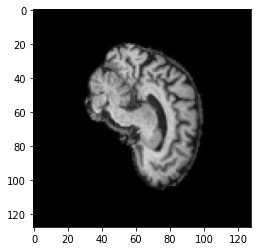

In [9]:
import matplotlib.pyplot as plt

plt.imshow(train[0])
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches


Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


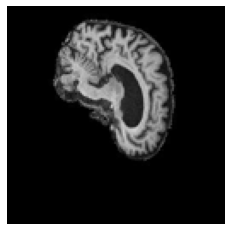

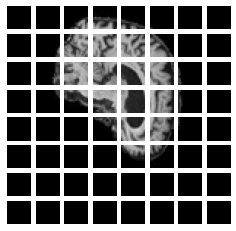

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
image_size = IMAGE_SIZE
patch_size = 16

plt.figure(figsize=(4, 4))
image = train[np.random.choice(range(train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

plt.imshow(tf.convert_to_tensor([image]).numpy().astype("uint8")[0])
plt.axis("off")
patches = Patches(patch_size)(image.reshape(1, image_size, image_size, 3))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [22]:
batch_size = 256
num_epochs = 100
num_patches = (image_size // patch_size) **2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim *2,
    projection_dim,
  ]
transformer_layers = 8
mlp_head_units = [2048, 1024]

def MLP(layer, hidden_count, dropout):
  for i in hidden_count:
    layer = layers.Dense(i, activation = tf.keras.activations.gelu)(layer)
    layer = layers.Dropout(dropout)(layer)
  return layer

In [6]:
num_classes = 2
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [12]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded
  

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train)

In [14]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = MLP(x3, hidden_count=transformer_units, dropout=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = MLP(representation, hidden_count=mlp_head_units, dropout=0.5)
    # Classify outputs.
    output = layers.Dense(num_classes, activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [15]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [ ]:
import tensorflow_addons as tfa

learning_rate = 0.0015
weight_decay = 0.0005

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, 
        weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    checkpoint_filepath = "/content/gdrive/MyDrive/checkpoints"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    #print("Arrived before model.fit")
    history = model.fit(
        x=train,
        y=trainy,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(test, testy)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
#vit_classifier.summary()
history = run_experiment(vit_classifier)

Epoch 1/100
72/72 [==============================] - 22s 156ms/step - loss: 1.5980 - accuracy: 0.5424 - val_loss: 0.7649 - val_accuracy: 0.0025
Epoch 2/100
72/72 [==============================] - 10s 140ms/step - loss: 0.6806 - accuracy: 0.5679 - val_loss: 0.7989 - val_accuracy: 0.0387
Epoch 3/100
72/72 [==============================] - 10s 139ms/step - loss: 0.6712 - accuracy: 0.5821 - val_loss: 0.9143 - val_accuracy: 0.0496
Epoch 4/100
38/72 [==============>...............] - ETA: 4s - loss: 0.6702 - accuracy: 0.5854

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


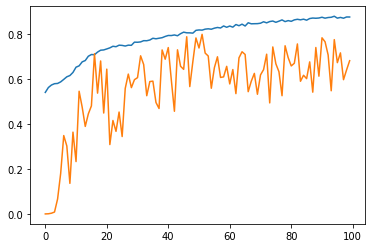

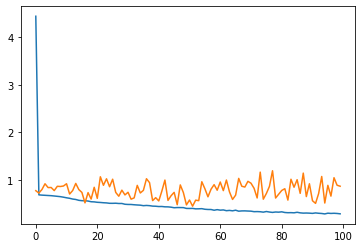

In [20]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [1]:
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-12d1520b-cbdf-4def-378c-a04d85ac0570)
